In [1]:
import pandas as pd
import numpy as np
import re

#### import packages:
- we use spacy 3.0 with model 'en_core_web_lg'
- we'll need spacy DependencyMatcher

In [2]:
import spacy
from spacy.matcher import DependencyMatcher
nlp = spacy.load('en_core_web_lg')
matcher = DependencyMatcher(nlp.vocab)

In [3]:
dramas = pd.read_csv('review_resolve_emoji.csv', index_col = 0)
dramas.head()

,title,review
0,Goblin,"If you are hesitating to watch this at all, pl..."
1,Goblin,I feel compelled to write a review for Goblin ...
2,Goblin,It must be said that Goblin is very much a som...
3,Goblin,Every moment of it indeed shined! Goblin is a ...
4,Goblin,"Somewhere inside Goblin, buried under a mound ..."


#### create a main couple dictionary for look up
- We found that people like to use main couple to refer to the actor/acctress in the drama. Out of the lines that we can match, about 1/3 used 'main couple', so we decided to include that
- We assume the first two with opposite gender in the cast list are main couple

In [4]:
roles = pd.read_csv('roles_mod.csv', index_col = 0)
roles = roles.fillna('')
roles.head()

,Title,CharName,Role,MainCouple,ActorName,Gender,Image
0,When Time Stopped,KimSunAh,Main Role,Yes,AhnJiHyun,Female,https://i.mydramalist.com/0NwROc.jpg
1,Itaewon Class,"JangGeunWon,Jangga'ssuccessor]",Support Role,No,AhnBoHyun,Male,https://i.mydramalist.com/EoxeQ_5c.jpg
2,Her Private Life,NamEunGi,Support Role,No,AhnBoHyun,Male,https://i.mydramalist.com/EoxeQ_5c.jpg
3,My Only Love Song,MuMyung,Support Role,No,AhnBoHyun,Male,https://i.mydramalist.com/EoxeQ_5c.jpg
4,Wednesday 3:30 PM,BaekSeungGyu,Main Role,No,AhnBoHyun,Male,https://i.mydramalist.com/EoxeQ_5c.jpg


In [5]:
titles = list(dramas['title'].unique())
cp_dict = {}
for title in titles:
    df = roles[roles['Title']==title]
    df = df[df['MainCouple']=='Yes']
    name = list(df['ActorName'].values)
    gender = list(df['Gender'].values)
    if gender[0] != gender[1]:
        name = [''.join(nam.split()) for nam in name]
        cp_dict[title] = (name[0], name[1])
cp_dict

{'Goblin': ('GongYoo', 'KimGoEun'),
 'Strong Woman Do Bong Soon': ('ParkBoYoung', 'ParkHyungShik'),
 'Descendants of the Sun': ('SongHyeKyo', 'SongJoongKi'),
 'W': ('HanHyoJoo', 'LeeJongSuk'),
 'You Who Came from the Stars': ('JunJiHyun', 'KimSooHyun'),
 'Weightlifting Fairy Kim Bok Joo': ('LeeSungKyung', 'NamJooHyuk'),
 'The Heirs': ('LeeMinHo', 'ParkShinHye'),
 'Pinocchio': ('LeeJongSuk', 'ParkShinHye'),
 'Healer': ('JiChangWook', 'ParkMinYoung'),
 "What's Wrong with Secretary Kim": ('ParkMinYoung', 'ParkSeoJoon'),
 'While You Were Sleeping': ('BaeSuzy', 'LeeJongSuk'),
 'Moon Lovers: Scarlet Heart Ryeo': ('IU', 'LeeJoonGi'),
 'Secret Garden': ('HaJiWon', 'HyunBin'),
 'Kill Me, Heal Me': ('HwangJungEum', 'JiSung'),
 'The Legend of the Blue Sea': ('JunJiHyun', 'LeeMinHo'),
 'Crash Landing on You': ('HyunBin', 'SonYeJin'),
 'City Hunter': ('LeeMinHo', 'ParkMinYoung'),
 'I Hear Your Voice': ('LeeBoYoung', 'LeeJongSuk'),
 'She Was Pretty': ('HwangJungEum', 'ParkSeoJoon'),
 "I'm Not a Robo

- use aggregate to put all individual reviews into one

In [6]:
dramas = dramas.groupby('title', sort=False).aggregate({'review':'sum'})

#### create a dict for each pair
- it is a bipartite pair for everyone in the cast list

In [7]:
couple_dict = {v:[] for k, v in cp_dict.items()}
for title in titles:
    df = roles[roles['Title']==title]
    actorsList = list(df['ActorName'])
    for i in range(len(actorsList)):
        for j in range(i+1, len(actorsList)):
            if (actorsList[i], actorsList[j]) not in couple_dict and (actorsList[j], actorsList[i]) not in couple_dict:
                couple_dict[(actorsList[i], actorsList[j])] = []

#### character name-real name dict:
- for each drama, create a cast list and look up dict (whenever we match the character name, we can know the corresponding actor name)

In [8]:
def casts_dict(df): # take in df = roles[roles['Title'==title]] as argument
    char = list(df['CharName'].values)
    casts = list(df['ActorName'])
    lookUp_dict = {}
    i=0
    for ch in char:
        temp = ch.split(',')
        lookUp_dict[casts[i]]=temp
        if ch != '':
            casts += temp
        i+=1
    return lookUp_dict, casts

- define patterns to match. Keywords = ['chemistry', 'relationship', 'OTP (one true pairing)', 'ship', 'root (for)', 'romance', 'bromance']

In [9]:
# chemistry
pattern1 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "chem_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "chem_prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}}, #conj: between A and B; amod: between the male cast; compound: between Goblin couple
    }
]# chem between A and B
pattern2 = [
    {
        "RIGHT_ID": "chem_root",
        "RIGHT_ATTRS": {"LEMMA": {"IN": ["have", "share", "illustrate"]}}
    },
    {
        "LEFT_ID": "chem_root",
        "REL_OP": ">",
        "RIGHT_ID": "subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "chem_root",
        "REL_OP": ">", 
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry", "DEP": "dobj"},
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "chem_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "chem_prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    }
]# A have chem with B
pattern3 = [
    {
        "RIGHT_ID": "chem_root",
        "RIGHT_ATTRS": {"LEMMA": {"IN": ["have", "share", "illustrate"]}}
    },
    {
        "LEFT_ID": "chem_root",
        "REL_OP": ">",
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry", "DEP": "dobj"},
    },
    {
        "LEFT_ID": "chem_root",
        "REL_OP": ">",
        "RIGHT_ID": "subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "subject",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound", "conj"]}},
    }
]# A and B have chem
pattern4 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "obj1",
        "RIGHT_ATTRS": {"DEP": "nmod"},
    },
    {
        "LEFT_ID": "obj1",
        "REL_OP": ">", 
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"DEP": "conj"},
    }
] # A and B's chem
pattern5 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "chem_poss",
        "RIGHT_ATTRS": {"DEP": "poss"},
    },
    {
        "LEFT_ID": "chem_poss",
        "REL_OP": ">", 
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]
# main lead's chemistry
pattern6 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "chem_poss",
        "RIGHT_ATTRS": {"DEP": {"IN": ["poss", "compound", "amod"]}},
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "chem_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "chem_prep",
        "REL_OP": ">", 
        "RIGHT_ID": "obj",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    }
] # A('s) chem with B
pattern7 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "clause",
        "RIGHT_ATTRS": {"DEP": "relcl"},
    },
    {
        "LEFT_ID": "clause",
        "REL_OP": ">",
        "RIGHT_ID": "subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "subject",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "compound", "amod"]}}, #conj: A and B; amod: male cast; compound: Goblin couple
    }
]# the chemistry A and B have was amazing
pattern8 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"LOWER": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "chem_poss",
        "RIGHT_ATTRS": {"DEP": {"IN": ["compound", "poss"]}},
    },
    {
        "LEFT_ID": "chem_poss",
        "REL_OP": ";*", 
        "RIGHT_ID": "and",
        "RIGHT_ATTRS": {"LOWER": "and"},
    },
    {
        "LEFT_ID": "and",
        "REL_OP": "<",
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"},
    }
] # A and B('s) chem
pattern9 = [
    {
        "RIGHT_ID": "chemistry",
        "RIGHT_ATTRS": {"ORTH": "chemistry"}
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "compound",
        "RIGHT_ATTRS": {"DEP": "compound"},
    },
    {
        "LEFT_ID": "chemistry",
        "REL_OP": ">", 
        "RIGHT_ID": "amod",
        "RIGHT_ATTRS": {"DEP": "amod"},
    }
] # main leads chem
matcher.add("CHEMISTRY1", [pattern1])
matcher.add("CHEMISTRY2", [pattern2])
matcher.add("CHEMISTRY3", [pattern3])
matcher.add("CHEMISTRY4", [pattern4])
matcher.add("CHEMISTRY5", [pattern5])
matcher.add("CHEMISTRY6", [pattern6])
matcher.add("CHEMISTRY7", [pattern7])
matcher.add("CHEMISTRY8", [pattern8])
matcher.add("CHEMISTRY9", [pattern9])

In [10]:
# relationship
pattern1 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "rel_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "rel_prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}}, #conj: between A and B; amod: between the male cast; compound: between Goblin couple
    }
]# relationship between/of A and B
pattern2 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "obj1",
        "RIGHT_ATTRS": {"DEP": "nmod"},
    },
    {
        "LEFT_ID": "obj1",
        "REL_OP": ">", 
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"DEP": "conj"},
    }
] # A and B's relationship
pattern3 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "rel_poss",
        "RIGHT_ATTRS": {"DEP": "poss"},
    },
    {
        "LEFT_ID": "rel_poss",
        "REL_OP": ">", 
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "nummod", "compound"]}},
    }
] # main couple's relationship
pattern4 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "rel_poss",
        "RIGHT_ATTRS": {"DEP": {"IN": ["poss", "compound", "amod"]}},
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "rel_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "rel_prep",
        "REL_OP": ">", 
        "RIGHT_ID": "obj",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    }
] # A('s) relationship with B
pattern5 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "rel_poss",
        "RIGHT_ATTRS": {"DEP": {"IN": ["compound", "poss"]}},
    },
    {
        "LEFT_ID": "rel_poss",
        "REL_OP": ";*", 
        "RIGHT_ID": "and",
        "RIGHT_ATTRS": {"ORTH": "and"},
    },
    {
        "LEFT_ID": "and",
        "REL_OP": "<",
        "RIGHT_ID": "conj",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"},
    }
] # A and B('s) relationship (improper: Sunny and GrimReaper's)
pattern6 = [
    {
        "RIGHT_ID": "relationship",
        "RIGHT_ATTRS": {"LOWER": "relationship"}
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "compound",
        "RIGHT_ATTRS": {"DEP": "compound"},
    },
    {
        "LEFT_ID": "relationship",
        "REL_OP": ">", 
        "RIGHT_ID": "amod",
        "RIGHT_ATTRS": {"DEP": "amod"},
    }
] # main leads relationship (improper)
matcher.add("RELATIONSHIP1", [pattern1])
matcher.add("RELATIONSHIP2", [pattern2])
matcher.add("RELATIONSHIP3", [pattern3])
matcher.add("RELATIONSHIP4", [pattern4])
matcher.add("RELATIONSHIP5", [pattern5])
matcher.add("RELATIONSHIP6", [pattern6])

In [11]:
# OTP
pattern1 = [
    {
        "RIGHT_ID": "OTP",
        "RIGHT_ATTRS": {"LOWER": "otp"}
    },
    {
        "LEFT_ID": "OTP",
        "REL_OP": "<", #'.*''
        "RIGHT_ID": "be",
        "RIGHT_ATTRS": {"LEMMA": "be"}
    },
    {
        "LEFT_ID": "be",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "conj"}, #conj: between A and B; amod: between the male cast; compound: between Goblin couple
    }
]# A and B are OTP
pattern2 = [
    {
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"}
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "OTP",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "nmod", "compound"], "LOWER": "otp"}},
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "conj"},
    }
]# OTP A and B
pattern3 = [
    {
        "RIGHT_ID": "OTP",
        "RIGHT_ATTRS": {"LOWER": "otp"}
    },
    {
        "LEFT_ID": "OTP",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "poss"},
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ";*",
        "RIGHT_ID": "and",
        "RIGHT_ATTRS": {"ORTH": "and"},
    },
    {
        "LEFT_ID": "and",
        "REL_OP": "<",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"},
    }
]# A and B's OTP(optional)
pattern4 = [
    {
        "RIGHT_ID": "otp",
        "RIGHT_ATTRS": {"LOWER": "otp"}
    },
    {
        "LEFT_ID": "otp",
        "REL_OP": ">",
        "RIGHT_ID": "prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "prep",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]# otp between A and B
pattern5 = [
    {
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"}
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "conj"}, 
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">",
        "RIGHT_ID": "as",
        "RIGHT_ATTRS": {"DEP": "prep", "LOWER": "as"},
    },
    {
        "LEFT_ID": "as",
        "REL_OP": ">",
        "RIGHT_ID": "OTP",
        "RIGHT_ATTRS": {"DEP": "pobj", "LOWER": "otp"},
    }
]# A and B as OTP
matcher.add("OTP1", [pattern1])
matcher.add("OTP2", [pattern2])
matcher.add("OTP3", [pattern3])
matcher.add("OTP4", [pattern4])
matcher.add("OTP5", [pattern5])

In [12]:
# ship
pattern1 = [
    {
        "RIGHT_ID": "ship",
        "RIGHT_ATTRS": {"LOWER": "ship", "POS": "VERB"}
    },
    {
        "LEFT_ID": "ship",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "dobj"}
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]# (I) ship A and B
pattern2 = [
    {
        "RIGHT_ID": "ship",
        "RIGHT_ATTRS": {"LOWER": "ship", "POS": "VERB"}
    },
    {
        "LEFT_ID": "ship",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "ship",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "prep",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    }
]# ship A with B
pattern3 = [
    {
        "RIGHT_ID": "is",
        "RIGHT_ATTRS": {"LEMMA": "be"}
    },
    {
        "LEFT_ID": "is",
        "REL_OP": ">",
        "RIGHT_ID": "ship",
        "RIGHT_ATTRS": {"DEP": "nsubj", "LOWER": "ship"},
    },
    {
        "LEFT_ID": "is",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": "attr"},
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]# (my) ship is A and B
pattern4 = [
    {
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"}
    },
    {
        "LEFT_ID": "A",
        "REL_OP": ".*",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"ENT_TYPE": "PERSON"},
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ".",
        "RIGHT_ID": "ship",
        "RIGHT_ATTRS": {"LOWER": "ship", "POS": "NOUN"},
    }
]# the A and B ship
pattern5 = [
    {
        "RIGHT_ID": "ship",
        "RIGHT_ATTRS": {"LOWER": "ship", "POS": "NOUN"}
    },
    {
        "LEFT_ID": "ship",
        "REL_OP": ">",
        "RIGHT_ID": "prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "prep",
        "REL_OP": ">",
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]# the ship with A and B
matcher.add("SHIP1", [pattern1])
matcher.add("SHIP2", [pattern2])
matcher.add("SHIP3", [pattern3])
matcher.add("SHIP4", [pattern4])
matcher.add("SHIP5", [pattern5])

In [13]:
# root for
pattern1 = [
    {
        "RIGHT_ID": "root",
        "RIGHT_ATTRS": {"LOWER": "root", "POS": "VERB"}
    },
    {
        "LEFT_ID": "root",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "prep",
        "RIGHT_ATTRS": {"DEP": "prep"}
    },
    {
        "LEFT_ID": "prep",
        "REL_OP": ">", #'.*''
        "RIGHT_ID": "B",
        "RIGHT_ATTRS": {"DEP": "pobj"}
    },
    {
        "LEFT_ID": "B",
        "REL_OP": ">",
        "RIGHT_ID": "A",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
]# root for A and B/main couple
matcher.add("ROOT", [pattern1])

In [14]:
#bromance
pattern1 = [
    {
        "RIGHT_ID": "bromance",
        "RIGHT_ATTRS": {"LOWER": "bromance"}
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": ">",
        "RIGHT_ID": "prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": "conj"},
    }
] #bromance between/of/with A and B [3,2]

pattern2 = [
    {
        "RIGHT_ID": "had",
        "RIGHT_ATTRS": {"LEMMA": "have"},
    },
    {
        "LEFT_ID": "had",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "object1",
        "RIGHT_ATTRS": {"DEP": "conj"},
    },
    {
        "LEFT_ID": "had",
        "REL_OP": ">",
        "RIGHT_ID": "bromance",
        "RIGHT_ATTRS": {"DEP": "dobj", "LOWER": "bromance"},
    }
] # A and B had bromance [1,2]

pattern3 = [
    {
        "RIGHT_ID": "bromance",
        "RIGHT_ATTRS": {"LOWER": "bromance"},
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": {"IN": ["compound", "poss"]}},
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": ">",
        "RIGHT_ID": "with",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "with",
        "REL_OP": ">",
        "RIGHT_ID": "object2",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
] # A('s) bromance with B [1,3]                   

pattern4 = [
    {
        "RIGHT_ID": "bromance",
        "RIGHT_ATTRS": {"LOWER": "bromance"},
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": ">",
        "RIGHT_ID": "bromance_poss",
        "RIGHT_ATTRS": {"DEP": "poss"},
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": "<",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "conj"},
    },
] # A and B's bromance [1,2]                       

pattern5 = [
    {
        "RIGHT_ID": "bromance",
        "RIGHT_ATTRS": {"LOWER": "bromance"},
    },
    {
        "LEFT_ID": "bromance",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "compound"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    },
] # A-B bromance [2,1]                                
matcher.add("BROMANCE1", [pattern1])
matcher.add("BROMANCE2", [pattern2])
matcher.add("BROMANCE3", [pattern3])
matcher.add("BROMANCE4", [pattern4])
matcher.add("BROMANCE5", [pattern5])

In [15]:
#romance
pattern1 = [
    {
        "RIGHT_ID": "romance",
        "RIGHT_ATTRS": {"LOWER": "romance"},
    },
    {
        "LEFT_ID": "romance",
        "REL_OP": ">",
        "RIGHT_ID": "romance_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "romance_prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct",
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    }
] # romance between A and B [3,2]                                   

pattern2 = [
    {
        "RIGHT_ID": "romance",
        "RIGHT_ATTRS": {"LOWER": "romance"},
    },
    {
        "LEFT_ID": "romance",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "nmod"},
    },
    {
        "LEFT_ID": "object",
        "REL_OP": ">",
        "RIGHT_ID": "conjunct", 
        "RIGHT_ATTRS": {"DEP": {"IN": ["conj", "amod", "compound"]}},
    },
] # A and B romance [2,1]                                              

pattern3 = [
    {
        "RIGHT_ID": "romance",
        "RIGHT_ATTRS": {"LOWER": "romance"},
    },
    {
        "LEFT_ID": "romance",
        "REL_OP": ">",
        "RIGHT_ID": "romance_prep",
        "RIGHT_ATTRS": {"DEP": "prep"},
    },
    {
        "LEFT_ID": "romance_prep",
        "REL_OP": ">",
        "RIGHT_ID": "object",
        "RIGHT_ATTRS": {"DEP": "pobj"},
    },
    {
        "LEFT_ID": "romance",
        "REL_OP": ">",
        "RIGHT_ID": "obj1",
        "RIGHT_ATTRS": {"DEP": "poss"},
    }
] # A's romance with B [2,3]
matcher.add("ROMANCE1", [pattern1])
matcher.add("ROMANCE2", [pattern2])
matcher.add("ROMANCE3", [pattern3])

#### Define find_obj functions: 
- `matcher(doc)` will return an id (which we can use it to get which pattern it is matching) and a list of token_ids in the doc (eg the first component 'chemistry' in the pattern appears at index 3 in the doc) <br>
We need to know which component corresponds to the object we want to find
(eg in CHEMISTRY1, the objects will be the [2] and [3] in token_ids because that's how we define it in the pattern). So in the function we'll say: <br>
`if nlp.vocab.strings[match_id]=='CHEMISTRY1':
    char1 = str(doc[token_ids[3]]) 
    char2 = str(doc[token_ids[2]])`

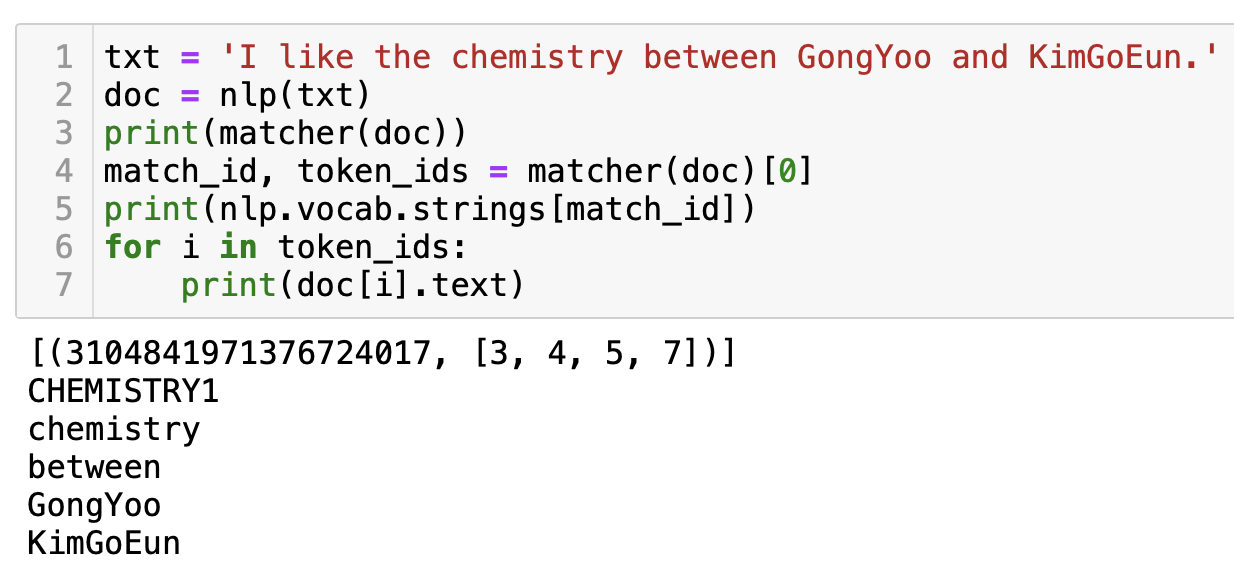

In [16]:
def find_obj(txt, title):
    doc = nlp(txt)
    matches = matcher(doc)
    for match in matches:
        match_id, token_ids = match
        if nlp.vocab.strings[match_id]=='CHEMISTRY1':
            char1 = str(doc[token_ids[3]]) 
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY2':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[4]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY3':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY4':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY5':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY6':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY7':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY8':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='CHEMISTRY9':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP1':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP2':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP3':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP4':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP5':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='RELATIONSHIP6':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='OTP1':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='OTP2':
            char1 = str(doc[token_ids[0]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='OTP3':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='OTP4':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='OTP5':
            char1 = str(doc[token_ids[0]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='SHIP1':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='SHIP2':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='SHIP3':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='SHIP4':
            char1 = str(doc[token_ids[0]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='SHIP5':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='BROMANCE1':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='BROMANCE2':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='BROMANCE3':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[3]])
        elif nlp.vocab.strings[match_id]=='BROMANCE4':
            char1 = str(doc[token_ids[1]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='BROMANCE5':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='ROMANCE1':
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
        elif nlp.vocab.strings[match_id]=='ROMANCE2':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[1]])
        elif nlp.vocab.strings[match_id]=='ROMANCE3':
            char1 = str(doc[token_ids[2]])
            char2 = str(doc[token_ids[3]])
        else: # match root for
            char1 = str(doc[token_ids[3]])
            char2 = str(doc[token_ids[2]])
            
        if char1 not in lookUp_dict: #char1 is not a dict key
            for actor, charList in lookUp_dict.items():
                if char1 in charList:
                    char1 = actor # if it is in the charList, after looking up the dict, we change it to 
                                  # corresponding actor's name, else, it stays the same
        if char2 not in lookUp_dict: #char2 is not a dict key
            for actor, charList in lookUp_dict.items():
                if char2 in charList:
                    char2 = actor
            
        check = char1+" "+char2
        if check.lower() in ['main casts', 'main leads', 'main couple']:
            if title in cp_dict: # for the dramas which we know the main couples, we can add as well
                char1, char2 = cp_dict[title]
  
        if (char1, char2) in couple_dict:
            if txt not in couple_dict[(char1, char2)]:
                couple_dict[(char1, char2)] = couple_dict[(char1, char2)] + [txt]
        elif (char2, char1) in couple_dict:
            if txt not in couple_dict[(char2, char1)]:
                couple_dict[(char2, char1)] = couple_dict[(char2, char1)] + [txt]

#### keywords, pattern matching:
- we first split the reviews by punctuations ( `;` or `:` or `!` or `?` or `.` )
- take all lines that contains keywords ('chemistry' 'OTP' 'relationship' 'ship' 'root' 'romance' 'bromance')
- for each drama, add entity_ruler to label everyone in the cast as PERSON, renew it for each drama
- for each list of keywords, find objects, if there is a match, add that to respective pair's list

In [17]:
for title in titles:
    ruler = nlp.add_pipe("entity_ruler", before='ner')
    text = dramas.loc[title, 'review']
    lines = re.split(';\s*|:\s*|!\s*|\?\s*|\.\s*', text)
    lines = [line for line in lines if not line.isspace() if line]
    
    chemistry = [line for line in lines if "CHEMISTRY" in line or "Chemistry" in line or 'chemistry' in line]
    OTP = [line for line in lines if "OTP" in line or "otp" in line]
    relation = [line for line in lines if "RELATIONSHIP" in line or "Relationship" in line or 'relationship' in line]
    ship = [line for line in lines if " SHIP " in line or " Ship " in line or ' ship ' in line]
    root = [line for line in lines if "ROOT" in line or "Root" in line or 'root' in line]
    romance = [line for line in lines if " ROMANCE " in line or " Romance " in line or ' romance ' in line]
    bromance = [line for line in lines if " BROMANCE " in line or " Bromance " in line or ' bromance ' in line]
    
    df = roles[roles['Title']==title]
    lookUp_dict, casts = casts_dict(df)
    for cast in casts:
        ruler.add_patterns([{"label": "PERSON", "pattern": cast}])
    for chem in chemistry:
        find_obj(chem, title)
    for otp in OTP:
        find_obj(otp, title)
    for rel in relation:
        find_obj(rel, title)
    for s in ship:
        find_obj(s, title)
    for r in root:
        find_obj(r, title)
    for rom in romance:
        find_obj(rom, title)
    for brom in bromance:
        find_obj(brom, title)
    
    nlp.remove_pipe('entity_ruler')

In [18]:
count = 0
for tup, List in couple_dict.items():
    if len(List) > 0:
        print(tup, List)
        print('\n')
        count+=1

('GongYoo', 'KimGoEun') ["i love the chemistry between the main leads sooooooo much i hope they make another drama with same cast specially LeeDongWook and YooInNa all about the story was amazing the romance parts was brilliant i love the romance parts except the religious part about god and angels i felt the romance parts was really disgracing my mind and the END as usual *if the writer was controlling destiny and God's behavior y the writer didn't make the goblin's bride immortal as the writer *y the writer didn't make the writer friend and the writer sister remembered the writer *y the writer insists till the end to torture and punish the writer for something wasn't the writer fault ommo that's really bothered me alotA lot of drama bite off more than they can chew when tackling plots and after binge watching show after show that couldn't neatly tie they story lines together, Goblin was a happy surprise", "Top notch cast check Great music check Dramatic (and very well made) backgroun

In [19]:
count
# we have 414 pairs with some comments about their chemistry

414

#### Sentiment analysis with TextBlob
- pass in list for each pair for sentiment analysis

In [20]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')
pair = []
actor1 = []
actor2 = []
lineCount = []
score = []
for k, v in couple_dict.items():
    pair.append(k)
    actor1.append(k[0])
    actor2.append(k[1])
    lineCount.append(len(v))
    text = '. '.join(v)
    doc = nlp(text)
    score.append(doc._.polarity)

#### create a new data frama with line count and scores

In [21]:
pair_df = pd.DataFrame({'pair': pair, 'actor1': actor1, 'actor2': actor2, 
                        'lineCount': lineCount, 'score': score})

- drop those with less than 5 lines

In [22]:
drop = list(pair_df[pair_df['lineCount']<5].index)
final = pair_df.drop(drop).sort_values('score', ascending=False).reset_index(drop=True)

In [23]:
final

,pair,actor1,actor2,lineCount,score
0,"(ChaSeungWon, LeeSeungGi)",ChaSeungWon,LeeSeungGi,5,0.592857
1,"(JungHaeIn, SonYeJin)",JungHaeIn,SonYeJin,9,0.501087
2,"(GoSungHee, YoonHyunMin)",GoSungHee,YoonHyunMin,5,0.487549
3,"(ChoiJinHyuk, SongJiHyo)",ChoiJinHyuk,SongJiHyo,5,0.478333
4,"(JungEunJi, KimJiSoo)",JungEunJi,KimJiSoo,6,0.466667
...,...,...,...,...,...
97,"(JoJungSuk, ParkBoYoung)",JoJungSuk,ParkBoYoung,8,0.105357
98,"(KimHeeAe, YooAhIn)",KimHeeAe,YooAhIn,5,0.098148
99,"(RoWoon, WonJinAh)",RoWoon,WonJinAh,7,0.047791
100,"(KimGoEun, ParkHaeJin)",KimGoEun,ParkHaeJin,8,0.025000


- export to csv

In [24]:
final.to_csv('senti.csv')